<a href="https://colab.research.google.com/github/e-pyrom/Build-Projects/blob/master/Build_2_Car_MSRP_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [0]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None
cars = pd.read_csv('https://raw.githubusercontent.com/e-pyrom/Build-Projects/master/cars_v2.csv')

In [69]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport

profile = ProfileReport(cars)
profile

Number of variables,17
Number of observations,8253
Total Missing (%),2.0%
Total size in memory,1.1 MiB
Average record size in memory,136.0 B
Numeric,8
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [70]:
cars.shape

(8253, 17)

In [71]:
# Value count for each unique value. Subset with Makes with more than 100 data points.
cars['Make'].value_counts()

Chevrolet        859
Volkswagen       754
Ford             651
Toyota           636
Nissan           469
Honda            426
Dodge            407
GMC              371
Mazda            340
Suzuki           308
Hyundai          275
Infiniti         226
Subaru           226
Kia              223
Mitsubishi       181
Volvo            170
Buick            166
Acura            165
Cadillac         161
Chrysler         159
Audi             151
Pontiac          141
BMW              141
Lincoln          119
Lexus            117
Saab              77
Mercedes-Benz     73
FIAT              62
Scion             60
Oldsmobile        57
Land Rover        56
HUMMER            17
Lotus              3
Genesis            2
Plymouth           2
Porsche            2
Name: Make, dtype: int64

In [72]:
cars['Make'].dtypes

dtype('O')

In [0]:
cars.replace({'Ford ': 'Ford'}, inplace=True)

In [74]:
#Dropping Makes with less than 100 data points

fewer = cars['Make'].value_counts()
cars = cars[~cars['Make'].isin(fewer[fewer < 100].index)]
cars.shape

(7842, 17)

In [75]:
cars['Make'].value_counts()

Chevrolet     859
Volkswagen    754
Ford          651
Toyota        636
Nissan        469
Honda         426
Dodge         407
GMC           371
Mazda         340
Suzuki        308
Hyundai       275
Infiniti      226
Subaru        226
Kia           223
Mitsubishi    181
Volvo         170
Buick         166
Acura         165
Cadillac      161
Chrysler      159
Audi          151
Pontiac       141
BMW           141
Lincoln       119
Lexus         117
Name: Make, dtype: int64

In [76]:
#Replaced all missing values with 'Unknown'
cars = cars.fillna('Unknown')
cars.isnull().sum()

Unnamed:_0           0
Make                 0
Model                0
Year                 0
Engine_Fuel_Type     0
Engine_HP            0
Engine_Cylinders     0
Transmission_Type    0
Driven_Wheels        0
Number_of_Doors      0
Market_Category      0
Vehicle_Size         0
Vehicle_Style        0
highway_MPG          0
city_mpg             0
Popularity           0
MSRP                 0
dtype: int64

In [77]:
cars['MSRP'].describe()

count     7842.000000
mean     30136.759628
std       8830.190968
min      10135.000000
25%      23495.000000
50%      29365.000000
75%      36400.000000
max      49995.000000
Name: MSRP, dtype: float64

In [78]:
#Define Market Categories, and fill in missing values
cars['Market_Category'].describe()

count        7842
unique         50
top       Unknown
freq         2571
Name: Market_Category, dtype: object

In [79]:
#Market Category column needs to be cleaned
cars['Market_Category'].value_counts()

Unknown                                          2571
Crossover                                        1094
Flex Fuel                                         805
Performance                                       506
Hatchback                                         458
Luxury                                            400
Luxury,Performance                                306
Crossover,Luxury                                  261
Hatchback,Performance                             227
High-Performance                                  146
Hybrid                                            117
Diesel                                             84
Crossover,Hatchback                                72
Hatchback,Hybrid                                   72
Crossover,Luxury,Performance                       66
Factory Tuner,High-Performance                     65
Factory Tuner,Performance                          63
Luxury,High-Performance                            63
Crossover,Flex Fuel         

In [80]:
#Replace high-performance with performance
cars['Market_Category'].replace({'High-Performance':'Performance'}, inplace=True)

cars['Transmission_Type'].value_counts()

#Create new columns for each unique category type
cars['Unknown'] = cars['Market_Category']== 'Unknown'
cars['Hatchback'] = cars['Market_Category']== 'Hatchback'
cars['Crossover'] = cars['Market_Category']== 'Crossover'
cars['Flex Fuel'] = cars['Market_Category']== 'Flex Fuel'
cars['Performance'] = cars['Market_Category']== 'Performance'
cars['Luxury'] = cars['Market_Category']== 'Luxury'
cars['Hybrid'] = cars['Market_Category']== 'Hybrid'
cars['Diesel'] = cars['Market_Category']== 'Diesel'
cars['Factory Tuner'] = cars['Market_Category']== 'Factory Tuner'

cars.head(5)

,Unnamed:_0,Make,Model,Year,Engine_Fuel_Type,Engine_HP,Engine_Cylinders,Transmission_Type,Driven_Wheels,Number_of_Doors,Market_Category,Vehicle_Size,Vehicle_Style,highway_MPG,city_mpg,Popularity,MSRP,Unknown,Hatchback,Crossover,Flex Fuel,Performance,Luxury,Hybrid,Diesel,Factory Tuner
0,0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135,False,False,False,False,False,False,False,False,False
1,1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650,False,False,False,False,False,False,False,False,False
2,2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350,False,False,False,False,False,False,False,False,False
3,3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450,False,False,False,False,False,False,False,False,False
4,4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500,False,False,False,False,False,True,False,False,False


In [81]:
#Drop original Market Category column
cars.drop(columns='Market_Category', inplace=True)
cars.shape

(7842, 25)

In [82]:
#Drop unneeded columns
drop_col = ['Unnamed:_0', 'Number_of_Doors', 'Popularity', 'Vehicle_Size']
cars.drop(columns=drop_col, inplace=True)
cars.shape

(7842, 21)

In [83]:
#Cleaning up Model column, high cardinality
cars['Model'].value_counts(ascending=True)

1 Series M              1
GS 430                  1
GX 460                  1
Zephyr                  1
RLX                     1
                     ... 
Sierra 1500            80
Beetle Convertible     89
F-150                  99
Tundra                136
Silverado 1500        147
Name: Model, Length: 502, dtype: int64

In [84]:
cars['Model'].describe()

count               7842
unique               502
top       Silverado 1500
freq                 147
Name: Model, dtype: object

In [86]:
#Dropping Models with more than 50 data points, avoid overfitting on those specific models
high_card = cars['Model'].value_counts()
cars = cars[~cars['Model'].isin(high_card[high_card > 50].index)]
cars.shape

(6444, 21)

In [87]:
#Dropping Makes with less than 100 data points
cars['Model'].value_counts()

Golf GTI                  50
XC60                      50
Sierra 1500 Classic       49
Silverado 1500 Classic    49
Transit Wagon             48
                          ..
GX 460                     1
K900                       1
5 Series                   1
Zephyr                     1
MKZ Hybrid                 1
Name: Model, Length: 484, dtype: int64

In [88]:
#Engine Fuel Type
cars['Engine_Fuel_Type'].value_counts()

regular unleaded                                4342
premium unleaded (recommended)                   923
premium unleaded (required)                      618
flex-fuel (unleaded/E85)                         448
diesel                                            57
electric                                          42
flex-fuel (unleaded/natural gas)                   6
flex-fuel (premium unleaded recommended/E85)       5
Unknown                                            3
Name: Engine_Fuel_Type, dtype: int64

In [89]:
#Replace current engine fuel types

cars['Engine_Fuel_Type'].replace({'premium unleaded (recommended)':'premium unleaded', 'premium unleaded (required)':'premium unleaded', 
                                 'flex-fuel (unleaded/E85)':'flex-fuel', 'flex-fuel (unleaded/natural gas)':'flex-fuel',
                                  'flex-fuel (premium unleaded recommended/E85)':'flex-fuel'}, inplace=True)

cars['Engine_Fuel_Type'].value_counts()

regular unleaded    4342
premium unleaded    1541
flex-fuel            459
diesel                57
electric              42
Unknown                3
Name: Engine_Fuel_Type, dtype: int64

In [90]:
#Cleaning up transmissions, combine automatic with automated_manual
cars['Transmission_Type'].value_counts()

AUTOMATIC           4918
MANUAL              1209
AUTOMATED_MANUAL     273
DIRECT_DRIVE          44
Name: Transmission_Type, dtype: int64

In [91]:
cars['Transmission_Type'].replace({'AUTOMATED_MANUAL':'AUTOMATIC'}, inplace=True)

cars['Transmission_Type'].value_counts()

AUTOMATIC       5191
MANUAL          1209
DIRECT_DRIVE      44
Name: Transmission_Type, dtype: int64

In [92]:
#Cleaning up Vehicle Style
cars['Vehicle_Style'].value_counts()

Sedan                  1817
4dr SUV                1760
4dr Hatchback           540
Wagon                   431
Coupe                   411
Passenger Minivan       279
Convertible             245
Crew Cab Pickup         217
2dr Hatchback           208
Extended Cab Pickup     185
Passenger Van           103
Regular Cab Pickup       91
Cargo Minivan            63
Cargo Van                49
2dr SUV                  30
Convertible SUV          15
Name: Vehicle_Style, dtype: int64

In [93]:
cars['Vehicle_Style'].replace({'4dr SUV':'SUV'}, inplace=True)
cars['Vehicle_Style'].replace({'4dr Hatchback':'Hatchback'}, inplace=True)
cars['Vehicle_Style'].replace({'Passenger Minivan':'Minivan'}, inplace=True)
cars['Vehicle_Style'].replace({'Crew Cab Pickup':'Pickup'}, inplace=True)
cars['Vehicle_Style'].replace({'2dr Hatchback':'Hatchback'}, inplace=True)
cars['Vehicle_Style'].replace({'Extended Cab Pickup':'Pickup'}, inplace=True)
cars['Vehicle_Style'].replace({'Passenger Van':'Minivan'}, inplace=True)
cars['Vehicle_Style'].replace({'Regular Cab Pickup':'Pickup'}, inplace=True)
cars['Vehicle_Style'].replace({'Cargo Minivan':'Cargo Van'}, inplace=True)
cars['Vehicle_Style'].replace({'2dr SUV':'SUV'}, inplace=True)
cars['Vehicle_Style'].replace({'Convertible SUV':'SUV'}, inplace=True)

cars['Vehicle_Style'].value_counts()

Sedan          1817
SUV            1805
Hatchback       748
Pickup          493
Wagon           431
Coupe           411
Minivan         382
Convertible     245
Cargo Van       112
Name: Vehicle_Style, dtype: int64

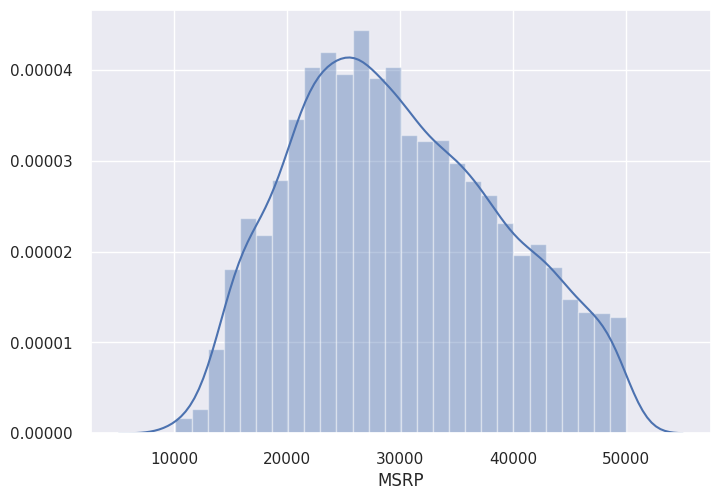

In [94]:
#Distribution of data

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

x = cars['MSRP']

sns.distplot(x)

In [96]:
cars.columns

Index(['Make', 'Model', 'Year', 'Engine_Fuel_Type', 'Engine_HP',
       'Engine_Cylinders', 'Transmission_Type', 'Driven_Wheels',
       'Vehicle_Style', 'highway_MPG', 'city_mpg', 'MSRP', 'Unknown',
       'Hatchback', 'Crossover', 'Flex Fuel', 'Performance', 'Luxury',
       'Hybrid', 'Diesel', 'Factory Tuner'],
      dtype='object')

In [0]:
#Categorical columns
X, y = cars.drop(columns='MSRP'), cars['MSRP']
X = pd.get_dummies(data=X)

In [98]:
X.head()

,Year,highway_MPG,city_mpg,Unknown,Hatchback,Crossover,Flex Fuel,Performance,Luxury,Hybrid,Diesel,Factory Tuner,Make_Acura,Make_Audi,Make_BMW,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_Ford,Make_GMC,Make_Honda,Make_Hyundai,Make_Infiniti,Make_Kia,Make_Lexus,Make_Lincoln,Make_Mazda,Make_Mitsubishi,Make_Nissan,Make_Pontiac,Make_Subaru,Make_Suzuki,Make_Toyota,Make_Volkswagen,Make_Volvo,Model_1 Series,Model_1 Series M,Model_2,Model_2 Series,Model_200,Model_3 Series,Model_3 Series Gran Turismo,Model_300,Model_300M,Model_350Z,Model_4 Series,Model_4 Series Gran Coupe,Model_4Runner,Model_5,Model_5 Series,Model_6,Model_626,Model_86,Model_A3,Model_A4,Model_A4 allroad,Model_A5,Model_A6,Model_ATS,Model_ATS Coupe,Model_Acadia,Model_Acadia Limited,Model_Accent,Model_Accord Crosstour,Model_Accord Hybrid,Model_Accord Plug-In Hybrid,Model_Aerio,Model_Altima,Model_Altima Hybrid,Model_Amanti,Model_Armada,Model_Aspen,Model_Astro,Model_Astro Cargo,Model_Avalanche,Model_Avalon,Model_Avalon Hybrid,Model_Avenger,Model_Aveo,Model_Aviator,Model_Azera,Model_Aztek,Model_B-Series,Model_B-Series Truck,Model_B9 Tribeca,Model_BRZ,Model_Baja,Model_Black Diamond Avalanche,Model_Blazer,Model_Bolt EV,Model_Bonneville,Model_Borrego,Model_C-Max Hybrid,Model_C30,Model_C70,Model_CC,Model_CL,Model_CR-V,Model_CR-Z,Model_CT 200h,Model_CTS,Model_CTS Coupe,Model_CTS Wagon,Model_CX-3,Model_CX-5,Model_CX-7,Model_CX-9,Model_Cabrio,Model_Cadenza,Model_Caliber,Model_Camaro,Model_Camry,Model_Camry Hybrid,Model_Camry Solara,Model_Canyon,Model_Captiva Sport,Model_Caravan,Model_Cascada,Model_Catera,Model_Cavalier,Model_Celica,Model_Century,Model_Challenger,Model_Charger,Model_City Express,Model_Classic,Model_Cobalt,Model_Concorde,Model_Continental,Model_Corolla,Model_Corolla iM,Model_Crossfire,Model_Crosstour,Model_Crosstrek,Model_Crown Victoria,Model_Cruze,Model_Cruze Limited,Model_Cube,Model_DTS,Model_Dart,Model_DeVille,Model_Diamante,Model_Durango,Model_E-Series Van,Model_E-Series Wagon,Model_ECHO,Model_ES 300,Model_ES 300h,Model_ES 330,Model_ES 350,Model_EX,Model_EX35,Model_Eclipse,Model_Eclipse Spyder,Model_Edge,Model_Elantra,Model_Elantra Coupe,Model_Elantra GT,Model_Elantra Touring,Model_Eldorado,Model_Element,Model_Enclave,Model_Encore,Model_Endeavor,Model_Entourage,Model_Envision,Model_Envoy,Model_Envoy XL,Model_Envoy XUV,Model_Eos,Model_Equator,Model_Equinox,Model_Escape,Model_Escape Hybrid,Model_Escort,Model_Esteem,Model_EuroVan,Model_Expedition,Model_Explorer,Model_Explorer Sport,Model_Explorer Sport Trac,Model_Express,Model_Express Cargo,Model_F-150 Heritage,Model_FJ Cruiser,Model_FX,Model_FX35,Model_FX45,Model_Fiesta,Model_Firebird,Model_Fit,Model_Fit EV,Model_Five Hundred,Model_Flex,Model_Focus,Model_Focus RS,Model_Focus ST,Model_Forenza,Model_Forester,Model_Forte,Model_Freestar,Model_Freestyle,Model_Fusion,Model_Fusion Hybrid,Model_G Convertible,Model_G Coupe,Model_G Sedan,Model_G20,Model_G3,Model_G35,Model_G37,Model_G37 Convertible,Model_G37 Coupe,Model_G37 Sedan,Model_G5,Model_G6,Model_G8,Model_GLI,Model_GS 200t,Model_GS 300,Model_GS 350,Model_GS 430,Model_GTO,Model_GX 460,Model_GX 470,Model_Galant,Model_Genesis,Model_Genesis Coupe,Model_Golf,Model_Golf Alltrack,Model_Golf GTI,Model_Golf R,Model_Golf SportWagen,Model_Grand Am,Model_Grand Caravan,Model_Grand Prix,Model_Grand Vitara,Model_HHR,Model_HR-V,Model_HS 250h,Model_Highlander,Model_Highlander Hybrid,Model_I30,Model_I35,Model_ILX,Model_ILX Hybrid,Model_IS 200t,Model_IS 250,Model_IS 250 C,Model_IS 300,Model_IS 350,Model_IS 350 C,Model_Impala,Model_Impala Limited,Model_Impreza,Model_Impreza WRX,Model_Insight,Model_Integra,Model_Intrepid,Model_JX,Model_Jetta GLI,Model_Jetta Hybrid,Model_Jetta SportWagen,Model_Jimmy,Model_Journey,Model_Juke,Model_K900,Model_Kizashi,Model_LHS,Model_LS,Model_LaCrosse,Model_Lancer,Model_Lancer Evolution,Model_Lancer Sportback,Model_LeSabre,Model_Leaf,Model_Legacy,Model_Lucerne,Model_Lumina,Model_M,Model_M35,Model_M37,Model_MDX,Model_MKC,Model_MKS,Model_MK

In [99]:
## Random train, val, test datasets
from sklearn.model_selection import train_test_split
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.20,
                                                  random_state=42)

#train and val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                   test_size=0.20, random_state=42)

print('Train split:', X_train.shape, 'Val split:', X_val.shape, 'Test split:', X_test.shape)

Train split: (4124, 756) Val split: (1031, 756) Test split: (1289, 756)


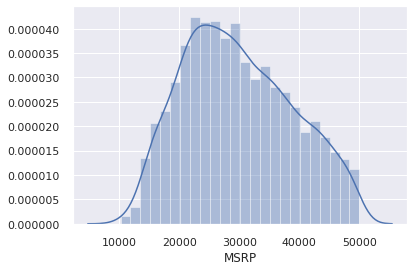

In [100]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [101]:
%%time
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

#Fit on train and score on val
pipeline.fit(X_train, y_train)

CPU times: user 37.3 s, sys: 2.47 s, total: 39.8 s
Wall time: 10.5 s


In [102]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Baseline Accuracy', accuracy_score(y_val, y_pred))

Baseline Accuracy 0.0533462657613967


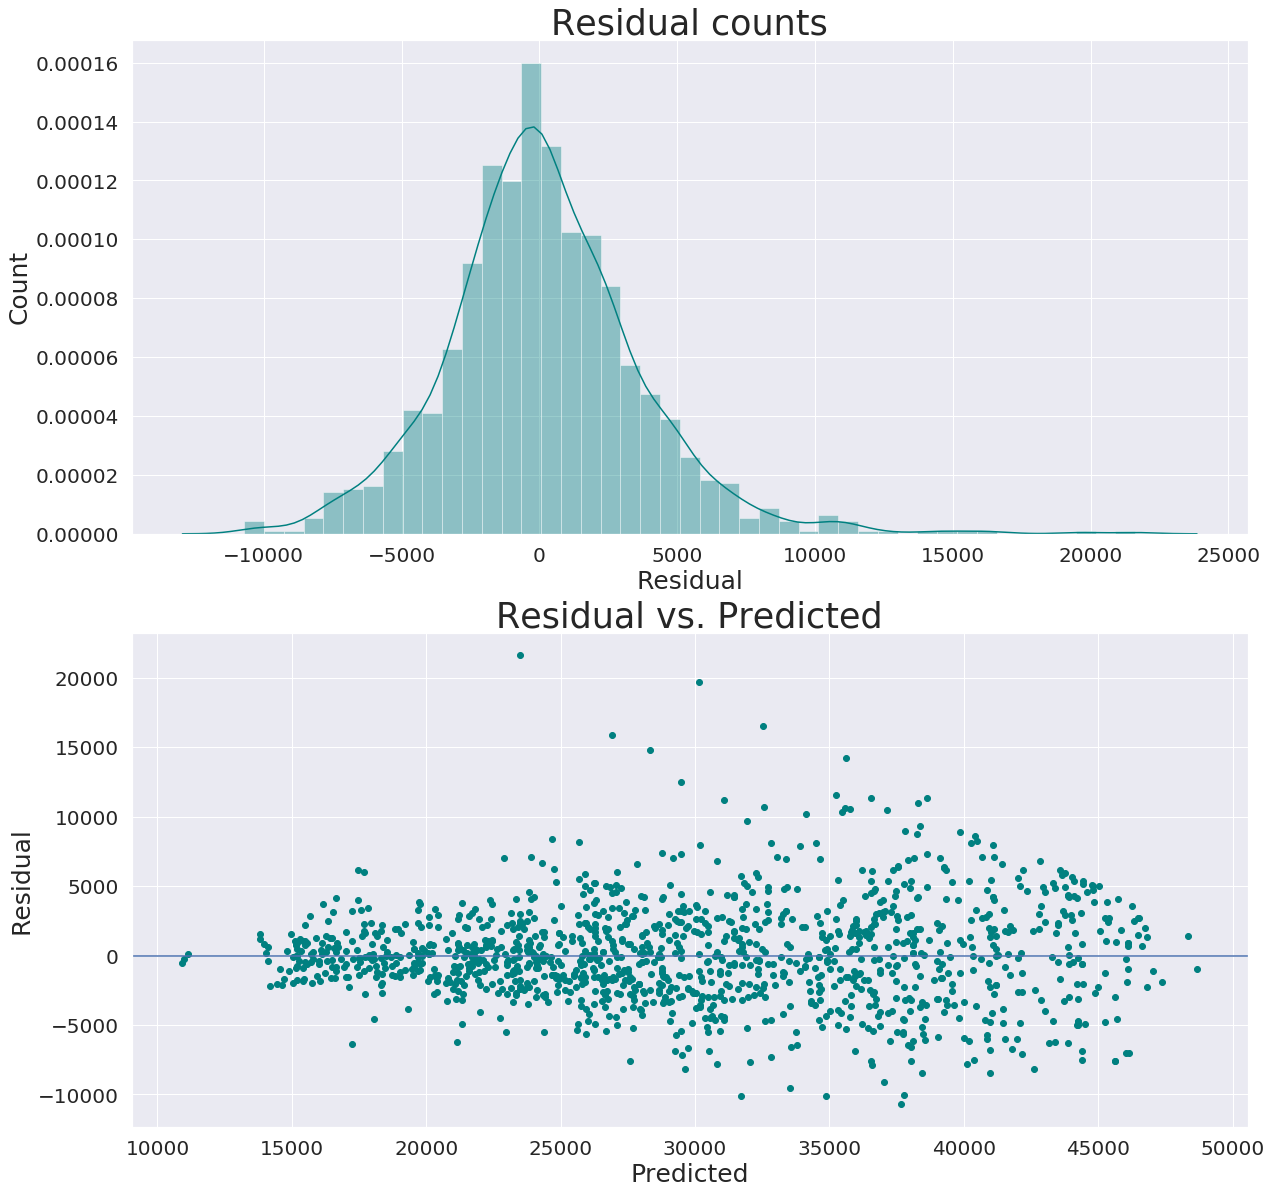

RMSE:
3549.0105701633634


In [108]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
residual = y_test - y_pred

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(y_pred, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:')
print(rmse)

In [111]:
from sklearn.metrics import r2_score
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Variance score: 0.85


In [0]:
rmse_l = []
num = []
for n in range(2, 16):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    num.append(n)

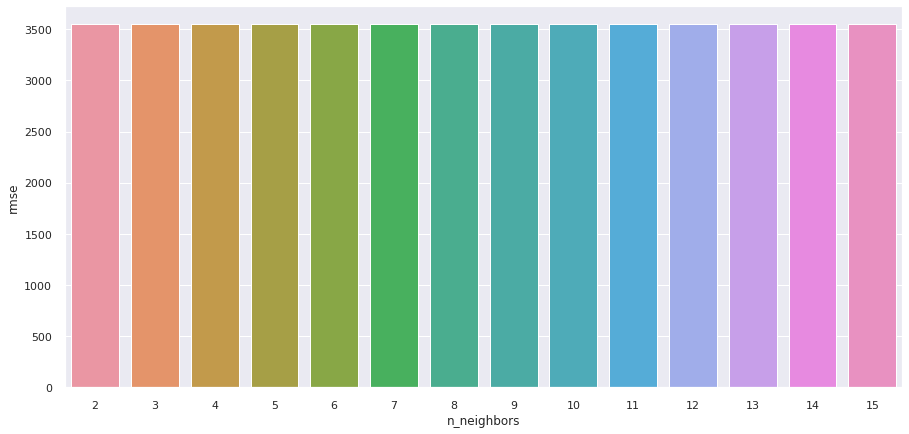

In [113]:
cars_plt = pd.DataFrame()
cars_plt['rmse'] = rmse_l
cars_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = cars_plt, x = 'n_neighbors', y = 'rmse')
plt.show()

In [34]:
##Linear Model
import category_encoders as ce
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(),  
    StandardScaler(),
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [35]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'median', 'selectkbest__k': 20, 'ridge__alpha': 0.1}
Cross-validation MAE -0.7077013121971887


In [119]:
#Cross validation
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20), 
    Ridge(alpha=.1)
)

k = 20
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='r2')
print(f'MAE for {k} folds:', scores)

MAE for 20 folds: [0.70356685 0.65150232 0.73583705 0.69993811 0.71357132 0.7132535
 0.72851639 0.66244186 0.69286851 0.78204426 0.7235083  0.74143969
 0.71834397 0.68478143 0.6988242  0.71489448 0.68690837 0.69465284
 0.68722528 0.69041356]


In [120]:
pipeline.fit(X_train, y_train)
print('Accuracy', pipeline.score(X_val, y_val))

Accuracy 0.7077477124631935


In [121]:
scores.mean()

0.7062266147728711

In [122]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 20
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='r2')
print(f'MAE for {k} folds:', scores)

MAE for 20 folds: [0.88211533 0.87728735 0.85722995 0.88416017 0.85241178 0.87717899
 0.88141704 0.84954747 0.86395645 0.88040378 0.89074943 0.87347713
 0.90186946 0.87522431 0.91134066 0.88632944 0.87711802 0.87598824
 0.88525286 0.87348496]


In [123]:
scores.mean()

0.8778271415214098

In [124]:
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=16, 
    scoring='r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 16 folds for each of 10 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 14.7min finished


In [125]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.48144342804345486, 'randomforestregressor__n_estimators': 472, 'simpleimputer__strategy': 'median', 'targetencoder__min_samples_leaf': 664}
Cross-validation MAE 0.8859262772920845


In [127]:
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {

    'targetencoder__min_samples_leaf': 664,    
    'simpleimputer__strategy': ['median'], 
    'randomforestregressor__n_estimators': randint(1,472), 
    'randomforestregressor__max_depth': [20], 
    'randomforestregressor__max_features': uniform(0.4814), 
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=16, 
    scoring='r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

#Accuracy Score
pipeline.fit(X_train, y_train)
print('Accuracy', pipeline.score(X_val, y_val))

Accuracy 0.8869100649076347


In [129]:
#Gradient Boosting Regressor

from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimatores=200, objectives='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

[03:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Gradient Boosting R^2 0.8248362426267012


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=72

In [131]:
!pip install pdpbox
!pip install shap

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Year'

isolated = pdp_isolate(
    model = gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

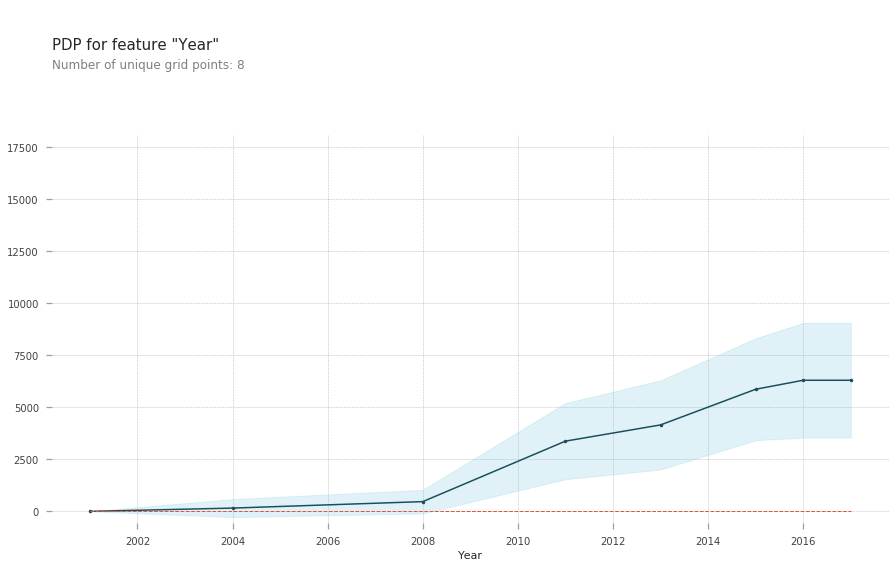

In [133]:
pdp_plot(isolated, feature_name=feature);

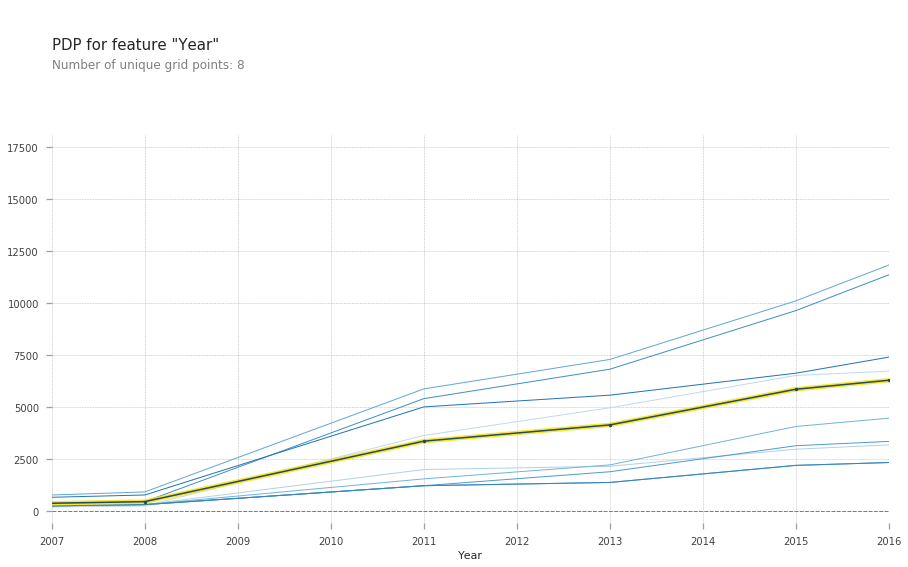

In [134]:
pdp_plot(isolated, feature_name=feature, plot_lines=True,
         frac_to_plot=0.01)

plt.xlim(2007,2016);

In [0]:
#Partial Dependence Plots with 2 Features

from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [153]:
X_val.columns.max

<bound method IndexOpsMixin.max of Index(['Year', 'highway_MPG', 'city_mpg', 'Unknown', 'Hatchback', 'Crossover',
       'Flex Fuel', 'Performance', 'Luxury', 'Hybrid',
       ...
       'Driven_Wheels_rear wheel drive', 'Vehicle_Style_Cargo Van',
       'Vehicle_Style_Convertible', 'Vehicle_Style_Coupe',
       'Vehicle_Style_Hatchback', 'Vehicle_Style_Minivan',
       'Vehicle_Style_Pickup', 'Vehicle_Style_SUV', 'Vehicle_Style_Sedan',
       'Vehicle_Style_Wagon'],
      dtype='object', length=756)>

In [0]:
features = ['highway_MPG', 'Year']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

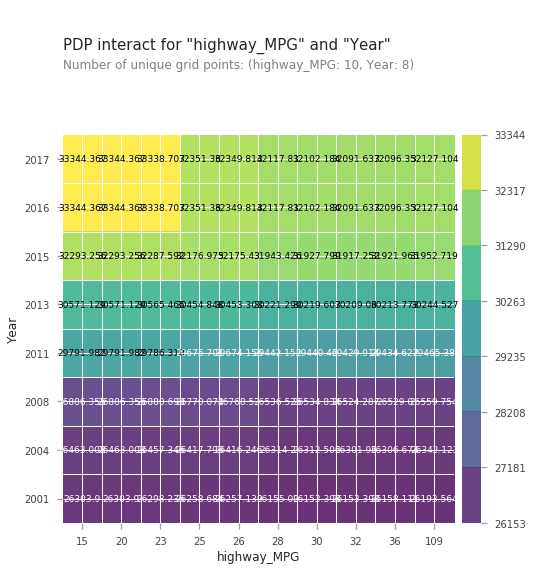

In [160]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features);

In [0]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

In [0]:
# Removing very low and high MPG
pdp = pdp.drop(columns=[15, 36])

In [0]:
target=y

In [163]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title='MSRP')
    )
)

fig = go.Figure(surface, layout)
fig.show()